In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
%cd /gdrive/My Drive/TESI MATTEO IV

Mounted at /gdrive
/gdrive/My Drive/TESI MATTEO IV


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch

In [ ]:
import os
os.listdir()

['D_ICD_DIAGNOSES.gsheet',
 'mimicIV_24h_diagnoses.csv',
 'mimicIV_24h_procedures.csv',
 'Embeddings Diagnoses Procedures',
 '24h_Procedures_embeddings.pkl',
 '90pca_transformed_embeddings_procedures.pkl',
 'mimicIV_24h_comorbidities.csv',
 '24h_Diagnoses_embeddings.pkl',
 '90pca_transformed_embeddings_diagnoses.pkl',
 'Prediction',
 'mimicIV_24h_complete_blood.csv',
 'mimicIV_24h_complete_lab.csv',
 'mimicIV_24h_complete_art.csv',
 'mimicIV_24h_prescriptions.csv',
 '24h_1MedicalPrescription_embeddings.pkl',
 '24h_4MedicalPrescription_embeddings.pkl',
 '24h_3MedicalPrescription_embeddings.pkl',
 '90pca_transformed_embeddings_prescription.pkl',
 '24h_2MedicalPrescription_embeddings.pkl',
 'mimicIV_24h_complete_demo.csv',
 'mimicIV_24h_additional.csv',
 'd_icd_diagnoses (1).gsheet',
 '1mimicIV_24h_complete_demo.csv',
 '1mimicIV_24h_additional.csv',
 '1mimicIV_24h_complete_art.csv',
 '1mimicIV_24h_complete_blood.csv',
 '1mimicIV_24h_complete_lab.csv',
 'combined_embeddings_matrix_standard

In [ ]:
df_procedures = pd.read_csv('mimicIV_24h_procedures.csv')
print(f"df shape: {df_procedures.shape}")

df shape: (168236, 7)


In [ ]:
df_procedures.head()

,subject_id,hadm_id,stay_id,icu_admission_time,icd_code,icd_version,procedure_description
0,10000032,29079034,39553978,2180-07-23 14:00:00,NaN,NaN,NaN
1,10000980,26913865,39765666,2189-06-27 08:42:00,0066,9.0,Percutaneous transluminal coronary angioplasty...
2,10000980,26913865,39765666,2189-06-27 08:42:00,3607,9.0,Insertion of drug-eluting coronary artery sten...
3,10000980,26913865,39765666,2189-06-27 08:42:00,0045,9.0,Insertion of one vascular stent
4,10000980,26913865,39765666,2189-06-27 08:42:00,0041,9.0,Procedure on two vessels


### COMPLETE ANALYSIS (remove nan values)

In [ ]:
# Filter out any rows that have at least one missing value
df_procedures = df_procedures.dropna()

print("Shape of DataFrame with complete cases:", df_procedures.shape)
df_procedures.head()

Shape of DataFrame with complete cases: (157730, 7)


,subject_id,hadm_id,stay_id,icu_admission_time,icd_code,icd_version,procedure_description
1,10000980,26913865,39765666,2189-06-27 08:42:00,0066,9.0,Percutaneous transluminal coronary angioplasty...
2,10000980,26913865,39765666,2189-06-27 08:42:00,3607,9.0,Insertion of drug-eluting coronary artery sten...
3,10000980,26913865,39765666,2189-06-27 08:42:00,0045,9.0,Insertion of one vascular stent
4,10000980,26913865,39765666,2189-06-27 08:42:00,0041,9.0,Procedure on two vessels
5,10000980,26913865,39765666,2189-06-27 08:42:00,3722,9.0,Left heart cardiac catheterization


### CONCATENATE LONG DIAGNOSES/PROCEDURES BY ICUSTAY_ID

In [ ]:
# Group by 'icustay_id' and concatenate the 'long_title' for each group
df_procedures_grouped = df_procedures.groupby('stay_id')['procedure_description'].agg(lambda titles: '; '.join(titles)).reset_index()
print(df_procedures_grouped.shape)
df_procedures_grouped.head()

(40053, 2)


,stay_id,procedure_description
0,30000153,Other partial resection of small intestine; Sm...
1,30000213,"Respiratory Ventilation, 24-96 Consecutive Hours"
2,30000484,"Venous catheterization, not elsewhere classifi..."
3,30001148,Single internal mammary-coronary artery bypass...
4,30001396,Non-invasive mechanical ventilation


### EMBEDDINGS

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel

def load_model_with_retry(model_name, retries=5):
    for i in range(retries):
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModel.from_pretrained(model_name)
            return tokenizer, model
        except Exception as e:
            wait = 2 ** i
            print(f"Attempt {i+1} failed with error {e}. Retrying in {wait} seconds.")
            time.sleep(wait)
    raise Exception("Failed to load model after several retries.")

# Usage
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer, model = load_model_with_retry(model_name)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# Find the maximum length of the tokens
df = df_procedures_grouped.copy()
tokenizer_test = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing and analyzing lengths
df['token_length'] = df['procedure_description'].apply(lambda x: len(tokenizer_test.tokenize(x)))

# Descriptive statistics for suggested max_length
stats = df['token_length'].describe(percentiles=[.95])
max_length_suggested = int(stats['95%'])

# Maximum token length for understanding the upper bound
max_length_maximum = df['token_length'].max()

print("Suggested max_length based on 95th percentile:", max_length_suggested)
print("Maximum token length in the dataset:", max_length_maximum)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


Suggested max_length based on 95th percentile: 127
Maximum token length in the dataset: 681


In [ ]:
def generate_embeddings(df, text_column, tokenizer, model):
    embeddings_dict = {}
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Embeddings"):
        text = row[text_column]
        icustay_id = row['stay_id']
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].numpy().squeeze()
        embeddings_dict[icustay_id] = embedding

    return embeddings_dict

In [7]:
import pickle

In [ ]:
procedures_embeddings_admissions = generate_embeddings(df_procedures_grouped, 'procedure_description', tokenizer, model)

Procedures_embeddings_file = '/gdrive/My Drive/TESI MATTEO IV/24h_Procedures_embeddings.pkl'

with open(Procedures_embeddings_file, 'wb') as file:
    pickle.dump(procedures_embeddings_admissions, file)

Generating Embeddings: 100%|██████████| 40053/40053 [50:49<00:00, 13.13it/s]


### IMPORT EMBEDDINGS

In [8]:
# Define the paths to the embeddings files for each subgroup
subgroup_files = [
    '/gdrive/My Drive/TESI MATTEO IV/24h_Procedures_embeddings.pkl'
]

# Initialize an empty dictionary to hold all embeddings
all_embeddings = {}

# Load each file and merge the dictionaries
for file_path in subgroup_files:
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
        all_embeddings.update(embeddings)

df_procedures_grouped = pd.DataFrame(list(all_embeddings.items()), columns=['stay_id', 'Embeddings'])

# Display the head of the DataFrame to verify
print(df_procedures_grouped.shape)
df_procedures_grouped.head()

(40053, 2)


,stay_id,Embeddings
0,30000153,"[0.3393671, 0.114209965, -0.24149382, -0.04819..."
1,30000213,"[-0.1651805, 0.3232383, -0.34642377, -0.569977..."
2,30000484,"[0.4345016, 0.10044653, -0.10343031, -0.001342..."
3,30001148,"[-0.03682773, 0.21283841, -0.22978726, -0.0702..."
4,30001396,"[-0.13446426, 0.45140484, 0.03176914, 0.090294..."


In [9]:
# Define the paths to the embeddings files for each subgroup
subgroup_files = [
    '/gdrive/My Drive/TESI MATTEO IV/24h_Diagnoses_embeddings.pkl'
]

# Initialize an empty dictionary to hold all embeddings
all_embeddings = {}

# Load each file and merge the dictionaries
for file_path in subgroup_files:
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
        all_embeddings.update(embeddings)

df_diagnoses_grouped = pd.DataFrame(list(all_embeddings.items()), columns=['stay_id', 'Embeddings'])

# Display the head of the DataFrame to verify
print(df_diagnoses_grouped.shape)
df_diagnoses_grouped.head()

(50540, 2)


,stay_id,Embeddings
0,30000153,"[0.055216346, 0.07852602, -0.32425928, 0.14874..."
1,30000213,"[-0.042923637, -0.12765323, -0.4834769, 0.2805..."
2,30000484,"[0.10458737, -0.22760755, -0.1583999, 0.345331..."
3,30001148,"[0.08230162, -0.1562352, -0.38145322, 0.290666..."
4,30001336,"[0.16675289, -0.08141287, -0.46072182, 0.26925..."


In [10]:
# Define the paths to the embeddings files for each subgroup
subgroup_files = [
    '/gdrive/My Drive/TESI MATTEO IV/24h_1MedicalPrescription_embeddings.pkl',
    '/gdrive/My Drive/TESI MATTEO IV/24h_2MedicalPrescription_embeddings.pkl',
    '/gdrive/My Drive/TESI MATTEO IV/24h_3MedicalPrescription_embeddings.pkl',
    '/gdrive/My Drive/TESI MATTEO IV/24h_4MedicalPrescription_embeddings.pkl'
]

# Initialize an empty dictionary to hold all embeddings
all_embeddings = {}

# Load each file and merge the dictionaries
for file_path in subgroup_files:
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
        all_embeddings.update(embeddings)

df_prescriptions_grouped = pd.DataFrame(list(all_embeddings.items()), columns=['stay_id', 'Embeddings'])

# Display the head of the DataFrame to verify
print(df_prescriptions_grouped.shape)
df_prescriptions_grouped.head()

(40066, 2)


,stay_id,Embeddings
0,30000153,"[0.25422546, -0.019283248, -0.22589009, 0.4821..."
1,30000484,"[0.34430957, 0.080360144, -0.28666493, 0.51361..."
2,30001148,"[0.3176487, 0.01986816, -0.15024547, 0.4449668..."
3,30001336,"[0.3104475, -0.04064364, -0.27751422, 0.528819..."
4,30001396,"[0.1973952, 0.023247747, -0.2516353, 0.6550003..."


### COMBINE EMBEDDINGS

In [11]:
# Drop duplicates based on 'ICUSTAY_ID'
df_procedures_grouped = df_procedures_grouped.drop_duplicates(subset='stay_id')

# Ensure each embedding is actually a numpy array and stack them vertically
embeddings_list = df_procedures_grouped['Embeddings'].tolist()
icustay_ids = df_procedures_grouped['stay_id'].values
combined_embeddings_matrix = np.vstack(embeddings_list)

# Verify the shape
print("Shape of combined embeddings matrix:", combined_embeddings_matrix.shape)

Shape of combined embeddings matrix: (40053, 768)


In [12]:
# Drop duplicates based on 'ICUSTAY_ID'
df_diagnoses_grouped = df_diagnoses_grouped.drop_duplicates(subset='stay_id')

# Ensure each embedding is actually a numpy array and stack them vertically
embeddings_list = df_diagnoses_grouped['Embeddings'].tolist()
icustay_ids = df_diagnoses_grouped['stay_id'].values
combined_embeddings_diag = np.vstack(embeddings_list)

# Verify the shape
print("Shape of combined embeddings matrix:", combined_embeddings_diag.shape)

Shape of combined embeddings matrix: (50540, 768)


In [13]:
# Drop duplicates based on 'ICUSTAY_ID'
df_prescriptions_grouped = df_prescriptions_grouped.drop_duplicates(subset='stay_id')

# Ensure each embedding is actually a numpy array and stack them vertically
embeddings_list = df_prescriptions_grouped['Embeddings'].tolist()
icustay_ids = df_prescriptions_grouped['stay_id'].values
combined_embeddings_pres = np.vstack(embeddings_list)

# Verify the shape
print("Shape of combined embeddings matrix:", combined_embeddings_pres.shape)

Shape of combined embeddings matrix: (40066, 768)


### STANDARDIZATION

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
# Scale the data prior to applying PCA
scaler = StandardScaler()
combined_embeddings_matrix_standardized = scaler.fit_transform(combined_embeddings_matrix)

In [16]:
# Scale the data prior to applying PCA
scaler = StandardScaler()
combined_embeddings_diag_standardized = scaler.fit_transform(combined_embeddings_diag)

In [17]:
# Scale the data prior to applying PCA
scaler = StandardScaler()
combined_embeddings_pres_standardized = scaler.fit_transform(combined_embeddings_pres)

### PCA

In [18]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [ ]:
pca = PCA().fit(combined_embeddings_matrix_standardized)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find the number of components for 95% and 90% of explained variance
components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('PCA for Procedures', fontsize=16)
plt.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', linewidth=2, label='90% Explained Variance')
plt.axvline(x=components_95, color='r', linestyle='--', linewidth=2)
plt.axvline(x=components_90, color='g', linestyle='--', linewidth=2)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Highlight the points of interest
plt.scatter(components_95 - 1, 0.95, color='r', s=100, zorder=5)
plt.scatter(components_90 - 1, 0.90, color='g', s=100, zorder=5)

# Annotate the points of interest
plt.text(components_95, 0.95, f'  {components_95} components', color='r', fontsize=12, verticalalignment='bottom')
plt.text(components_90, 0.90, f'  {components_90} components', color='g', fontsize=12, verticalalignment='bottom')

plt.show()

# Print the number of components for 95% and 90% of explained variance
print(f"Number of components to explain 95% variance: {components_95}")
print(f"Number of components to explain 90% variance: {components_90}")

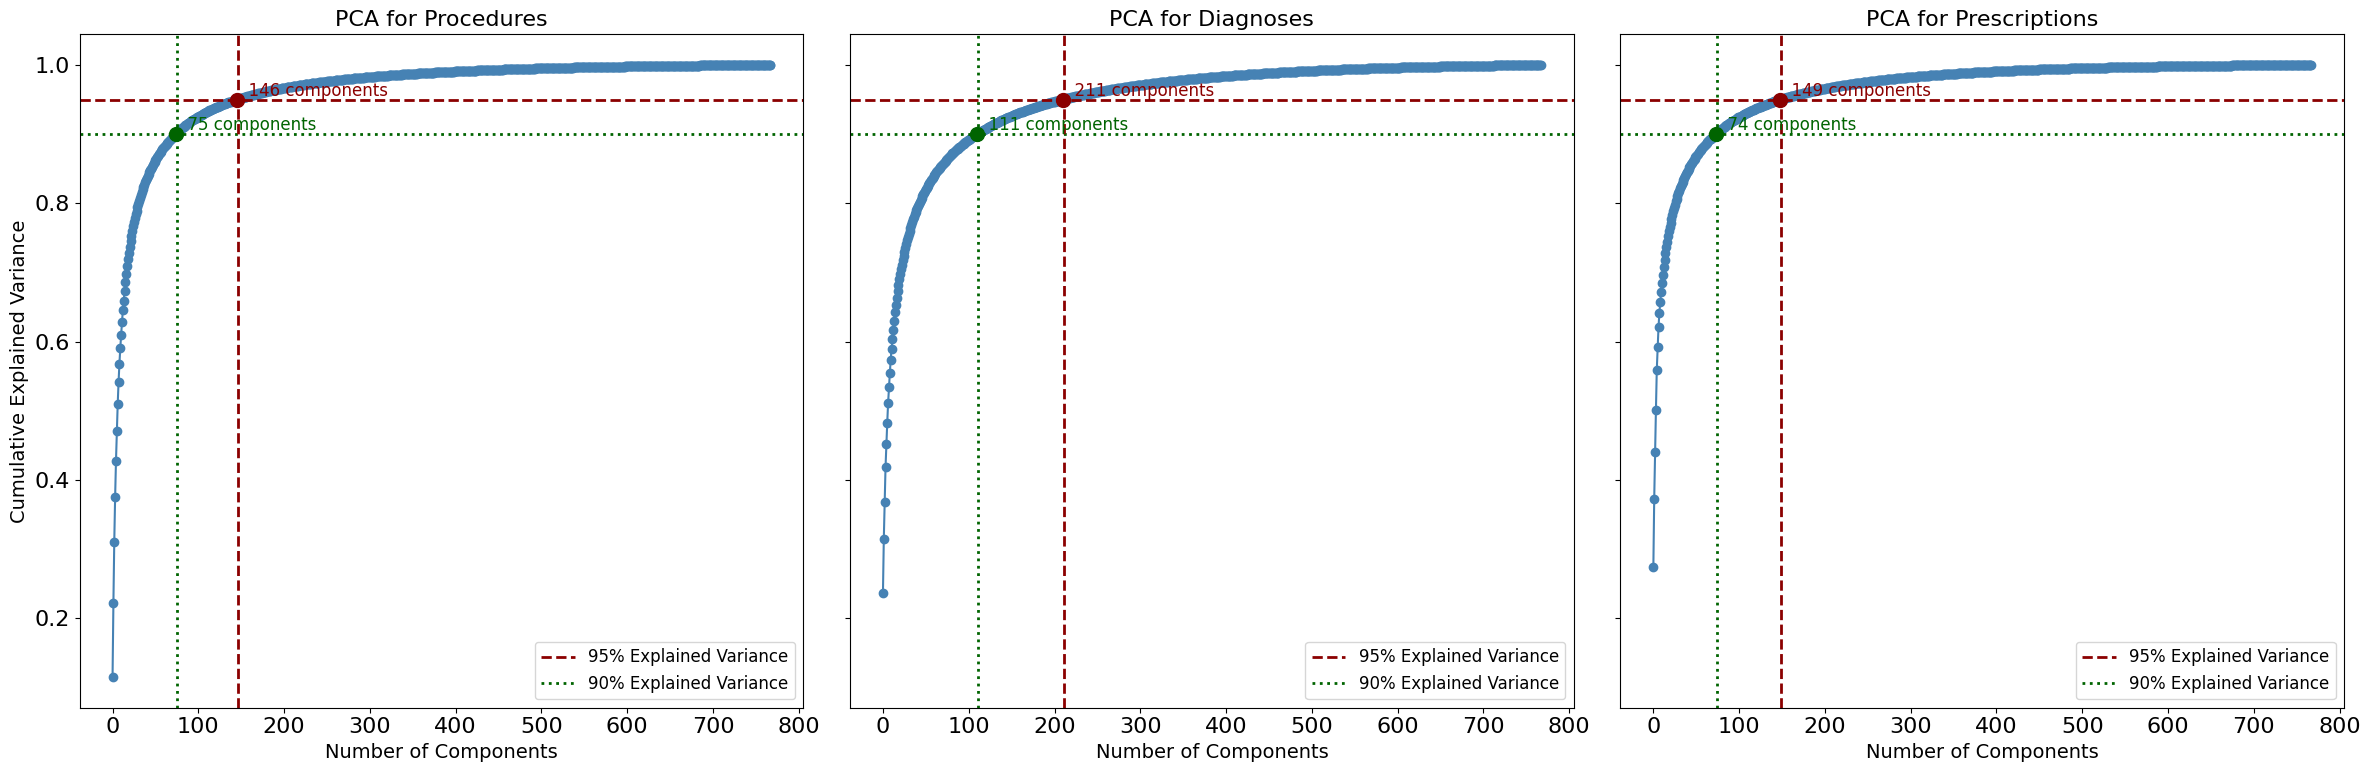

Number of components to explain 95% variance for Procedures: 146
Number of components to explain 90% variance for Procedures: 75
Number of components to explain 95% variance for Diagnoses: 211
Number of components to explain 90% variance for Diagnoses: 111
Number of components to explain 95% variance for Prescriptions: 149
Number of components to explain 90% variance for Prescriptions: 74


In [19]:
# Function to calculate PCA and cumulative variance
def calculate_pca_and_variance(data):
    pca = PCA().fit(data)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
    components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
    return cumulative_variance, components_95, components_90

# Calculate PCA for each dataset
cumulative_variance_procedures, components_95_procedures, components_90_procedures = calculate_pca_and_variance(combined_embeddings_matrix_standardized)
cumulative_variance_diagnoses, components_95_diagnoses, components_90_diagnoses = calculate_pca_and_variance(combined_embeddings_diag_standardized)
cumulative_variance_prescriptions, components_95_prescriptions, components_90_prescriptions = calculate_pca_and_variance(combined_embeddings_pres_standardized)

# Plotting the PCA results side by side with shared y-axis and new colors
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

# Define new colors
line_color = 'steelblue'
scatter_color_95 = 'darkred'
scatter_color_90 = 'darkgreen'
line_style_95 = 'dashed'
line_style_90 = 'dotted'

# Plot for Procedures
axes[0].plot(cumulative_variance_procedures, marker='o', linestyle='-', color=line_color)
axes[0].set_xlabel('Number of Components', fontsize=14)
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=14)
axes[0].set_title('PCA for Procedures', fontsize=16)
axes[0].axhline(y=0.95, color=scatter_color_95, linestyle=line_style_95, linewidth=2, label='95% Explained Variance')
axes[0].axhline(y=0.90, color=scatter_color_90, linestyle=line_style_90, linewidth=2, label='90% Explained Variance')
axes[0].axvline(x=components_95_procedures, color=scatter_color_95, linestyle=line_style_95, linewidth=2)
axes[0].axvline(x=components_90_procedures, color=scatter_color_90, linestyle=line_style_90, linewidth=2)
axes[0].legend(loc='best', fontsize=12)
# axes[0].grid(True)
axes[0].scatter(components_95_procedures - 1, 0.95, color=scatter_color_95, s=100, zorder=5)
axes[0].scatter(components_90_procedures - 1, 0.90, color=scatter_color_90, s=100, zorder=5)
axes[0].text(components_95_procedures, 0.95, f'  {components_95_procedures} components', color=scatter_color_95, fontsize=12, verticalalignment='bottom')
axes[0].text(components_90_procedures, 0.90, f'  {components_90_procedures} components', color=scatter_color_90, fontsize=12, verticalalignment='bottom')

# Plot for Diagnoses
axes[1].plot(cumulative_variance_diagnoses, marker='o', linestyle='-', color=line_color)
axes[1].set_xlabel('Number of Components', fontsize=14)
axes[1].set_title('PCA for Diagnoses', fontsize=16)
axes[1].axhline(y=0.95, color=scatter_color_95, linestyle=line_style_95, linewidth=2, label='95% Explained Variance')
axes[1].axhline(y=0.90, color=scatter_color_90, linestyle=line_style_90, linewidth=2, label='90% Explained Variance')
axes[1].axvline(x=components_95_diagnoses, color=scatter_color_95, linestyle=line_style_95, linewidth=2)
axes[1].axvline(x=components_90_diagnoses, color=scatter_color_90, linestyle=line_style_90, linewidth=2)
axes[1].legend(loc='best', fontsize=12)
# axes[1].grid(True)
axes[1].scatter(components_95_diagnoses - 1, 0.95, color=scatter_color_95, s=100, zorder=5)
axes[1].scatter(components_90_diagnoses - 1, 0.90, color=scatter_color_90, s=100, zorder=5)
axes[1].text(components_95_diagnoses, 0.95, f'  {components_95_diagnoses} components', color=scatter_color_95, fontsize=12, verticalalignment='bottom')
axes[1].text(components_90_diagnoses, 0.90, f'  {components_90_diagnoses} components', color=scatter_color_90, fontsize=12, verticalalignment='bottom')

# Plot for Prescriptions
axes[2].plot(cumulative_variance_prescriptions, marker='o', linestyle='-', color=line_color)
axes[2].set_xlabel('Number of Components', fontsize=14)
axes[2].set_title('PCA for Prescriptions', fontsize=16)
axes[2].axhline(y=0.95, color=scatter_color_95, linestyle=line_style_95, linewidth=2, label='95% Explained Variance')
axes[2].axhline(y=0.90, color=scatter_color_90, linestyle=line_style_90, linewidth=2, label='90% Explained Variance')
axes[2].axvline(x=components_95_prescriptions, color=scatter_color_95, linestyle=line_style_95, linewidth=2)
axes[2].axvline(x=components_90_prescriptions, color=scatter_color_90, linestyle=line_style_90, linewidth=2)
axes[2].legend(loc='best', fontsize=12)
# axes[2].grid(True)
axes[2].scatter(components_95_prescriptions - 1, 0.95, color=scatter_color_95, s=100, zorder=5)
axes[2].scatter(components_90_prescriptions - 1, 0.90, color=scatter_color_90, s=100, zorder=5)
axes[2].text(components_95_prescriptions, 0.95, f'  {components_95_prescriptions} components', color=scatter_color_95, fontsize=12, verticalalignment='bottom')
axes[2].text(components_90_prescriptions, 0.90, f'  {components_90_prescriptions} components', color=scatter_color_90, fontsize=12, verticalalignment='bottom')

plt.tight_layout()
plt.show()

# Print the number of components for 95% and 90% of explained variance for all datasets
print(f"Number of components to explain 95% variance for Procedures: {components_95_procedures}")
print(f"Number of components to explain 90% variance for Procedures: {components_90_procedures}")
print(f"Number of components to explain 95% variance for Diagnoses: {components_95_diagnoses}")
print(f"Number of components to explain 90% variance for Diagnoses: {components_90_diagnoses}")
print(f"Number of components to explain 95% variance for Prescriptions: {components_95_prescriptions}")
print(f"Number of components to explain 90% variance for Prescriptions: {components_90_prescriptions}")


In [ ]:
# Apply PCA with the optimal number of components found earlier
pca = PCA(n_components=components_90)
pca_transformed = pca.fit_transform(combined_embeddings_matrix_standardized)
pca_reconstructed = pca.inverse_transform(pca_transformed)

# Calculate MSE for PCA
pca_mse = mean_squared_error(combined_embeddings_matrix_standardized, pca_reconstructed)
print("PCA MSE:", pca_mse)

PCA MSE: 0.09899187


In [ ]:
# Combine PCA results back with ICUSTAY_ID
df_pca_transformed = pd.DataFrame(pca_transformed)
df_pca_transformed['stay_id'] = icustay_ids

# Verify structure
print(df_pca_transformed.head())

           0          1          2          3          4          5         6  \
0  -4.846107  11.428048  14.512654  -1.385251   6.151018  -4.749958 -1.095530   
1  25.933039  -1.943634  -7.341901  -6.478112  16.264725  -6.921959 -4.687505   
2  -2.291520   2.526728   6.200953   6.479298  -6.112345   3.995578  1.220507   
3  -9.406024  -2.269316   7.048419  -7.642583  -0.134638 -10.599283 -9.475019   
4  11.513932   4.718655 -13.318956 -10.783459  -3.700549  -5.059960 -1.500805   

          7          8         9  ...        66        67        68        69  \
0 -3.620292  -0.889383 -2.074069  ... -1.866954  0.348795 -0.701243 -0.300795   
1 -0.270638   4.663556 -6.550544  ... -0.543477 -1.570583  0.444396 -0.741263   
2  1.649823  10.568285 -4.652732  ... -0.896016 -1.748034 -2.578744  2.163352   
3  1.373258  -4.028364  3.570865  ...  1.219445  0.085304  0.923180  0.891209   
4  4.642881   3.857134  7.958176  ... -0.103916  0.415611  1.668534 -0.026621   

         70        71     

In [ ]:
# Save the PCA-transformed embeddings to a file
pca_embeddings_file = '/gdrive/My Drive/TESI MATTEO IV/90pca_transformed_embeddings_procedures.pkl'

with open(pca_embeddings_file, 'wb') as file:
    pickle.dump(df_pca_transformed, file)